# Example Code

In [2866]:
import pandas as pd

In [2867]:
data = pd.read_csv(r"C:\Users\user\Desktop\Asset Allocation\data\수익률데이터(2004~2024).csv", index_col=0)

In [2868]:
# matplotlib library load
import matplotlib.pyplot as plt


# plot 한글 보이게
from matplotlib import rc
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2869]:
returns = data.iloc[0:756]

In [2870]:
import cvxpy as cp
import numpy as np

# Calculate mean returns and covariance matrix
mean_returns = returns.mean().values  # Convert to numpy array
cov_matrix = returns.cov().values  # Convert to numpy array

# Number of assets
n_assets = returns.shape[1]

# Optimization variables
weights = cp.Variable(n_assets)

# Objective function (Maximize returns for a given level of risk)
risk_aversion = 3.5  # Risk aversion parameter
objective = cp.Maximize(mean_returns @ weights - risk_aversion * cp.quad_form(weights, cov_matrix))

# Constraints
constraints = [cp.sum(weights) == 1,  # Sum of weights should be 1
               weights >= 0,
               weights[0] >= 0.2]  # Long-only portfolio (no short selling)

# Problem
problem = cp.Problem(objective, constraints)

# Solve the problem
problem.solve()

# Results
optimized_weights = weights.value
optimized_weights, problem.status


(array([ 0.209 ,  0.464 , -0.    ,  0.3271]), 'optimal')

In [2871]:
import numpy as np
import pandas as pd

# 가정: returns는 각 자산의 일일 수익률을 담고 있는 pandas DataFrame입니다.
# 무위험 수익률 (연간 단위로 조정이 필요할 수 있습니다)
risk_free_rate = 0.

# 각 자산의 평균 수익률과 표준편차 계산
mean_returns = returns.mean() * 252  # 연간 수익률로 변환 (252 거래일 기준)
std_devs = returns.std() * np.sqrt(252)  # 연간 표준편차로 변환

# 샤프 비율 계산
sharpe_ratios = (mean_returns - risk_free_rate) / std_devs

# 샤프 비율 출력
print("Sharpe Ratios:")
print(sharpe_ratios)


Sharpe Ratios:
KOSPI 200_return    0.547584
S&P 500_return      0.723921
US_BOND_return      0.643597
KOR_BOND_return     2.812726
dtype: float64


---

# Target Returns

In [2872]:
TR_data = pd.read_excel(r"C:\Users\user\Desktop\Asset Allocation\data\(2012~2023) CPI + 실질 GDP.xlsx", index_col=0)
TR_data = TR_data.T
TR_data = TR_data.pct_change()
TR_data = TR_data.dropna(axis=0)
TR = pd.DataFrame(TR_data['CPI'] + TR_data['실질 GDP'], columns=['목표수익률'])
TR = TR[2:]

In [2873]:
TR

,목표수익률
2015,0.035149
2016,0.039213
2017,0.051017
2018,0.043835
2019,0.026296
2020,-0.001756
2021,0.068055
2022,0.077038
2023,0.049539


---

# BackTesting

In [2874]:
import pandas as pd

In [2875]:
df = pd.read_csv(r"C:\Users\user\Desktop\Asset Allocation\data\final_returns.csv", index_col=0)
df = df.dropna(axis = 0)

In [2876]:
cum_data = df.iloc[:,4:]

In [2877]:
returns_data = cum_data.pct_change()
returns_data = returns_data.dropna(axis = 0)
returns_data = returns_data.iloc[196:]
returns_data.columns = ['S&P 500', 'KOSPI 200', 'US Bond', 'Kor Bond', 'S&P 500 - Exposure', 'S&P 500 - Hedged', 'US Bond - Exposure', 'US Bond - Hedged']

In [2878]:
hedged_data = returns_data.loc[:, ['S&P 500 - Hedged', 'KOSPI 200','US Bond - Hedged', 'Kor Bond']]
exposure_data = returns_data.loc[:, ['S&P 500 - Exposure', 'KOSPI 200', 'US Bond - Exposure', 'Kor Bond']]

## 최적화 문제 정의

In [2879]:
import cvxpy as cp
import numpy as np


def weight_return(returns):
    np.set_printoptions(precision=4, suppress=True)
    # Calculate mean returns and covariance matrix
    mean_returns = returns.mean().values  # Convert to numpy array
    cov_matrix = returns.cov().values  # Convert to numpy array

    # Number of assets
    n_assets = returns.shape[1]

    # Optimization variables
    weights = cp.Variable(n_assets)

    # Objective function (Maximize returns for a given level of risk)
    risk_aversion = 4  # Risk aversion parameter
    objective = cp.Maximize(mean_returns@weights-risk_aversion*cp.quad_form(weights, cov_matrix))

    # Constraints
    constraints = [cp.sum(weights) == 1,  # Sum of weights should be 1
                weights >= 0,
   #             weights[0]>=0.2
   #             mean_returns@weights >= target_return
                ]  # 목표수익률 부등식제약조건

    # Problem
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    problem.solve()

    if problem.status not in ["infeasible", "unbounded"]:
        # If feasible and bounded, return the solution
        return weights.value
    else:
        # Handle cases where the problem has no solution
        raise ValueError(f"Problem status is {problem.status}, no solution found.")

## VAR

In [2880]:
from scipy.stats import norm

def VaR_value(confidence_level, weights, returns):

    portfolio_mean = returns.mean().dot(weights)
    portfolio_covariance = returns.cov()
    portfolio_std = np.sqrt(weights.T.dot(portfolio_covariance).dot(weights))

    VaR = norm.ppf(1 - confidence_level, portfolio_mean, portfolio_std)

#    x = np.linspace(portfolio_mean - 3*portfolio_std, portfolio_mean + 3*portfolio_std, 1000)
#    y = norm.pdf(x, portfolio_mean, portfolio_std)

    # Create the plot
#    plt.figure(figsize=(10, 6))
#    plt.plot(x, y, label='Normal Distribution')
#    plt.fill_between(x, y, where=(x <= VaR), color='red', alpha=0.5, label=f'Area below VaR at {confidence_level*100:.0f}% CL')
#    plt.axvline(x=VaR, color='red', linestyle='--', label=f'VaR at {confidence_level*100:.0f}% CL: {VaR:.2%}')
#    plt.axvline(x=portfolio_mean, color='blue', linestyle='-', label=f'Mean Return: {portfolio_mean:.2%}')

#    # Adding text labels for VaR and Mean Return
#    plt.text(VaR, max(y) * 0.9, f'VaR: {VaR:.2%}', horizontalalignment='right', color='red')
#    plt.text(portfolio_mean, max(y) * 0.9, f'Mean: {portfolio_mean:.2%}', horizontalalignment='left', color='blue')

#    plt.title('Normal Distribution with VaR and Mean Return')
#    plt.xlabel('Returns')
#    plt.ylabel('Probability Density')
#    plt.legend()
#    plt.grid(True)
#    plt.show()

    return(VaR)

## 평균분산 최적화 - Hedged

In [2881]:
portfolio_returns_hedged = pd.DataFrame()

for i in range(0, 8):
    # 가중치 적용 결과 계산
    weighted_returns = weight_return(hedged_data.iloc[256*i:256*(i+1)])

    print('가중치 : ', weighted_returns)
    print('예측 VAR : ',VaR_value(0.95, weighted_returns, hedged_data.iloc[256*(i):256*(i+1)])*100,'%')
    print('실제 VAR : ',VaR_value(0.95, weighted_returns, hedged_data.iloc[256*(i+1):256*(i+2)])*100,'%\n')
    
    # 다음 행에 대한 결과를 계산하여 연결
    new_returns = hedged_data.iloc[256*(i+1):256*(i+2)]@weighted_returns
    
    # 결과를 portfolio_returns에 추가
    portfolio_returns_hedged = pd.concat([portfolio_returns_hedged, new_returns])

# 결과 확인
portfolio_returns_hedged.columns = ['포트폴리오 수익률']

가중치 :  [ 0.  0. -0.  1.]
예측 VAR :  -0.10778557360447572 %
실제 VAR :  -0.13180901462857775 %

가중치 :  [0.6571 0.3429 0.     0.    ]
예측 VAR :  -0.8383620242013988 %
실제 VAR :  -0.9676221719346108 %

가중치 :  [ 0.554  0.446  0.    -0.   ]
예측 VAR :  -0.9465078285023998 %
실제 VAR :  -1.2547498897236438 %

가중치 :  [0.028 0.    0.972 0.   ]
예측 VAR :  -0.23485802410441559 %
실제 VAR :  -0.4892021440439818 %

가중치 :  [ 0.1386 -0.      0.8614  0.    ]
예측 VAR :  -0.44710963997225395 %
실제 VAR :  -0.33696590880804506 %

가중치 :  [0.4872 0.5128 0.     0.    ]
예측 VAR :  -1.1665241341812702 %
실제 VAR :  -1.6294822166235932 %

가중치 :  [ 0. -0.  0.  1.]
예측 VAR :  -0.28449487125073497 %
실제 VAR :  -0.33290354512131826 %

가중치 :  [ 0.2647  0.1904 -0.      0.545 ]
예측 VAR :  -0.6716162898477602 %
실제 VAR :  -0.5713596878802985 %



In [2882]:
portfolio_returns_hedged['누적 포트폴리오 수익률'] = (1 + portfolio_returns_hedged).cumprod() - 1

In [2883]:
portfolio_returns_hedged.index = pd.to_datetime(portfolio_returns_hedged.index)
portfolio_returns_hedged_percentile = portfolio_returns_hedged['누적 포트폴리오 수익률']*100

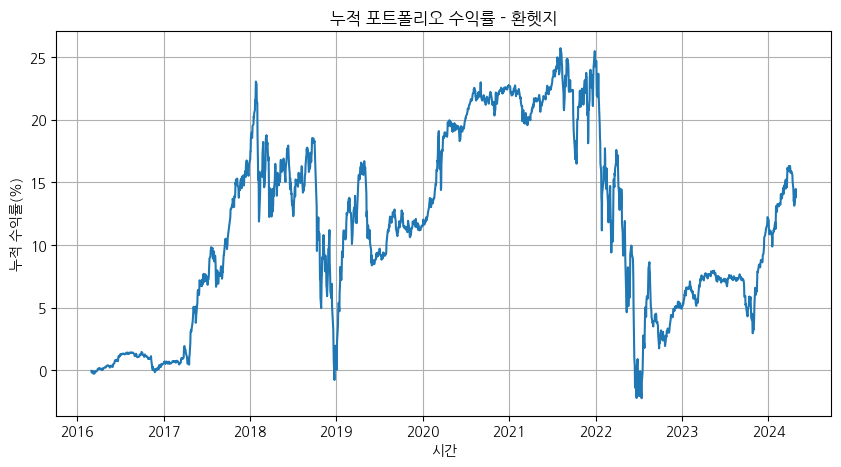

In [2884]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 누적 포트폴리오 수익률 그래프
plt.figure(figsize=(10, 5))  # 그래프 크기 설정
plt.plot(portfolio_returns_hedged_percentile)  # 선 그래프
plt.title('누적 포트폴리오 수익률 - 환헷지')  # 그래프 제목
plt.xlabel('시간')  # x축 라벨
plt.ylabel('누적 수익률(%)')  # y축 라벨
plt.grid(True)  # 그리드 표시

plt.show()  # 그래프 보여주기


In [2885]:
trad_portfolio_returns_hedged = pd.DataFrame()

for i in range(0, 8):
    # 가중치 적용 결과 계산
    weighted_returns = np.array([0.3,0.3,0.2,0.2])

    print('가중치 : ', weighted_returns)
    print('예측 VAR : ',VaR_value(0.95, weighted_returns, hedged_data.iloc[256*(i):256*(i+1)])*100,'%')
    print('실제 VAR : ',VaR_value(0.95, weighted_returns, hedged_data.iloc[256*(i+1):256*(i+2)])*100,'%\n')

    # 다음 행에 대한 결과를 계산하여 연결
    new_returns = hedged_data.iloc[256*(i+1):256*(i+2)]@weighted_returns
    
    # 결과를 portfolio_returns에 추가
    trad_portfolio_returns_hedged = pd.concat([trad_portfolio_returns_hedged, new_returns])

# 결과 확인
trad_portfolio_returns_hedged.columns = ['포트폴리오 수익률']

가중치 :  [0.3 0.3 0.2 0.2]
예측 VAR :  -0.756573371037375 %
실제 VAR :  -0.487550035797626 %

가중치 :  [0.3 0.3 0.2 0.2]
예측 VAR :  -0.487550035797626 %
실제 VAR :  -0.557514197987095 %

가중치 :  [0.3 0.3 0.2 0.2]
예측 VAR :  -0.557514197987095 %
실제 VAR :  -0.7151006341098488 %

가중치 :  [0.3 0.3 0.2 0.2]
예측 VAR :  -0.7151006341098488 %
실제 VAR :  -1.4618488090906903 %

가중치 :  [0.3 0.3 0.2 0.2]
예측 VAR :  -1.4618488090906903 %
실제 VAR :  -0.6861659488504941 %

가중치 :  [0.3 0.3 0.2 0.2]
예측 VAR :  -0.6861659488504941 %
실제 VAR :  -0.998166139376466 %

가중치 :  [0.3 0.3 0.2 0.2]
예측 VAR :  -0.998166139376466 %
실제 VAR :  -0.8365021254165063 %

가중치 :  [0.3 0.3 0.2 0.2]
예측 VAR :  -0.8365021254165063 %
실제 VAR :  -0.7634117617206078 %



In [2886]:
trad_portfolio_returns_hedged['누적 포트폴리오 수익률'] = (1 + trad_portfolio_returns_hedged['포트폴리오 수익률']).cumprod() - 1

In [2887]:
trad_portfolio_returns_hedged.index = pd.to_datetime(trad_portfolio_returns_hedged.index)
trad_portfolio_returns_hedged_percentile = trad_portfolio_returns_hedged['누적 포트폴리오 수익률']*100

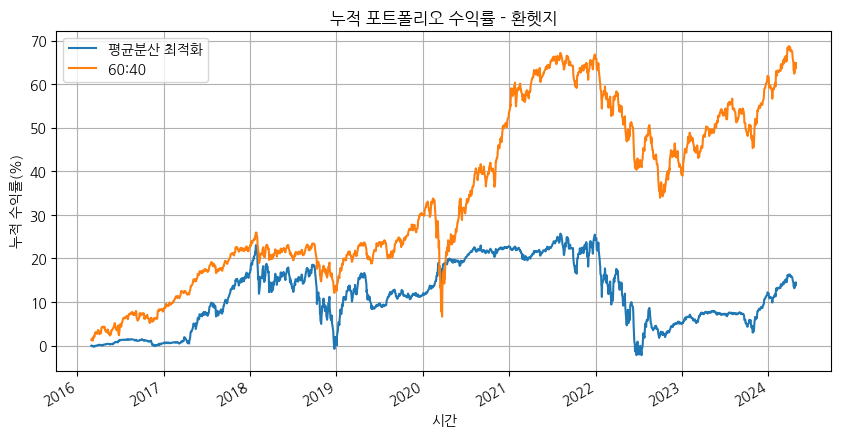

In [2888]:
import matplotlib.pyplot as plt
# 누적 포트폴리오 수익률 그래프
plt.figure(figsize=(10, 5))  # 그래프 크기 설정
plt.plot(portfolio_returns_hedged_percentile, label='평균분산 최적화')  # 선 그래프
plt.plot(trad_portfolio_returns_hedged_percentile, label='60:40')  # 선 그래프
plt.title('누적 포트폴리오 수익률 - 환헷지')  # 그래프 제목
plt.xlabel('시간')  # x축 라벨
plt.ylabel('누적 수익률(%)')  # y축 라벨
plt.grid(True)  # 그리드 표시

# x축 라벨이 겹치지 않도록 자동으로 조정
plt.gcf().autofmt_xdate()

plt.legend()
plt.show()  # 그래프 보여주기

In [2889]:
cum_snp_hedged = (1 + hedged_data['S&P 500 - Hedged']).cumprod() - 1
cum_snp_hedged.index = pd.to_datetime(cum_snp_hedged.index)

cum_KSP_hedged = (1 + hedged_data['KOSPI 200']).cumprod() - 1
cum_KSP_hedged.index = pd.to_datetime(cum_KSP_hedged.index)

cum_KorB_hedged = (1 + hedged_data['Kor Bond']).cumprod() - 1
cum_KorB_hedged.index = pd.to_datetime(cum_KorB_hedged.index)

cum_USBond_hedged = (1 + hedged_data['US Bond - Hedged']).cumprod() - 1
cum_USBond_hedged.index = pd.to_datetime(cum_USBond_hedged.index)

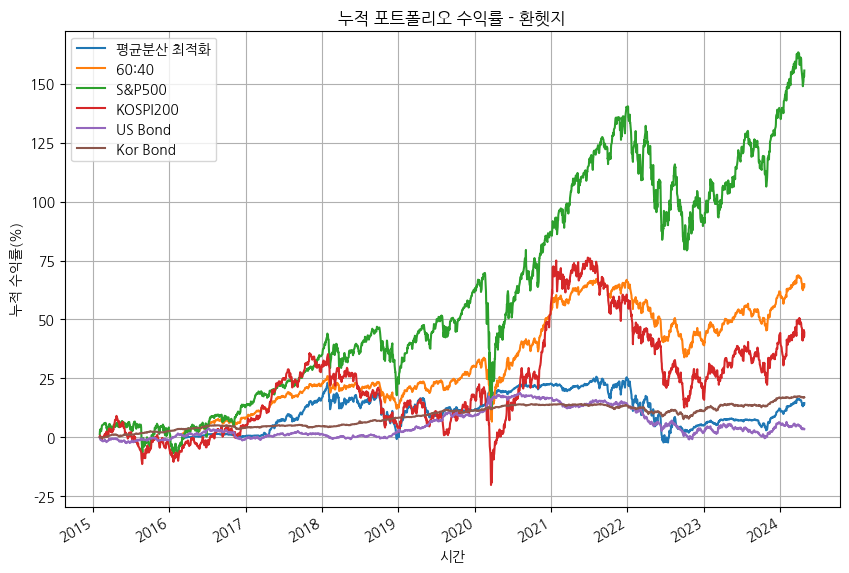

In [2890]:
import matplotlib.pyplot as plt
# 누적 포트폴리오 수익률 그래프
plt.figure(figsize=(10, 7))  # 그래프 크기 설정
plt.plot(portfolio_returns_hedged_percentile, label='평균분산 최적화')  # 선 그래프
plt.plot(trad_portfolio_returns_hedged_percentile, label='60:40')  # 선 그래프
plt.plot(cum_snp_hedged*100, label='S&P500')  # 선 그래프
plt.plot(cum_KSP_hedged*100, label='KOSPI200')
plt.plot(cum_USBond_hedged*100, label='US Bond')
plt.plot(cum_KorB_hedged*100, label='Kor Bond')
plt.title('누적 포트폴리오 수익률 - 환헷지')  # 그래프 제목
plt.xlabel('시간')  # x축 라벨
plt.ylabel('누적 수익률(%)')  # y축 라벨
plt.grid(True)  # 그리드 표시

# x축 라벨이 겹치지 않도록 자동으로 조정
plt.gcf().autofmt_xdate()

plt.legend()
plt.show()  # 그래프 보여주기

---

## 평균분산 최적화 - Exposure

In [2891]:
portfolio_returns_explosure = pd.DataFrame()

for i in range(0, 8):
    # 가중치 적용 결과 계산
    weighted_returns = weight_return(exposure_data.iloc[256*i:256*(i+1)])

    print('가중치 : ', weighted_returns)
    print('예측 VAR : ',VaR_value(0.95, weighted_returns, hedged_data.iloc[256*(i):256*(i+1)])*100,'%')
    print('실제 VAR : ',VaR_value(0.95, weighted_returns, hedged_data.iloc[256*(i+1):256*(i+2)])*100,'%\n')
    
    # 다음 행에 대한 결과를 계산하여 연결
    new_returns = exposure_data.iloc[256*(i+1):256*(i+2)]@weighted_returns
    
    # 결과를 portfolio_returns에 추가
    portfolio_returns_explosure = pd.concat([portfolio_returns_explosure, new_returns])

# 결과 확인
portfolio_returns_explosure.columns = ['포트폴리오 수익률']
print(portfolio_returns_explosure)

가중치 :  [ 0.  0.  1. -0.]
예측 VAR :  -0.33990052243295604 %
실제 VAR :  -0.34800735015884604 %

가중치 :  [ 0.0084  0.9916 -0.      0.    ]
예측 VAR :  -1.1112200136441857 %
실제 VAR :  -1.2394772325733838 %

가중치 :  [ 0.2949  0.7051 -0.     -0.    ]
예측 VAR :  -1.0098469322165884 %
실제 VAR :  -1.3122483294677043 %

가중치 :  [0.0167 0.     0.9833 0.    ]
예측 VAR :  -0.24432218268137665 %
실제 VAR :  -0.5116116327110777 %

가중치 :  [0.1571 0.0198 0.8231 0.    ]
예측 VAR :  -0.48664265479203045 %
실제 VAR :  -0.3376403080140006 %

가중치 :  [ 0.3557  0.6443 -0.     -0.    ]
예측 VAR :  -1.2656688978024615 %
실제 VAR :  -1.6400088267423685 %

가중치 :  [ 0.2434  0.      0.7566 -0.    ]
예측 VAR :  -0.6916782775276362 %
실제 VAR :  -0.7296797748726792 %

가중치 :  [0.238  0.1849 0.     0.5771]
예측 VAR :  -0.632357080770116 %
실제 VAR :  -0.5446501543630476 %

            포트폴리오 수익률
2016-03-02   0.000189
2016-03-03  -0.006085
2016-03-04  -0.012852
2016-03-07  -0.009459
2016-03-08  -0.003379
...               ...
2024-04-22   0.005468
2

In [2892]:
portfolio_returns_explosure['누적 포트폴리오 수익률'] = (1 + portfolio_returns_explosure['포트폴리오 수익률']).cumprod() - 1

In [2893]:
portfolio_returns_explosure.index = pd.to_datetime(portfolio_returns_explosure.index)
portfolio_returns_explosure_percentile = portfolio_returns_explosure['누적 포트폴리오 수익률']*100

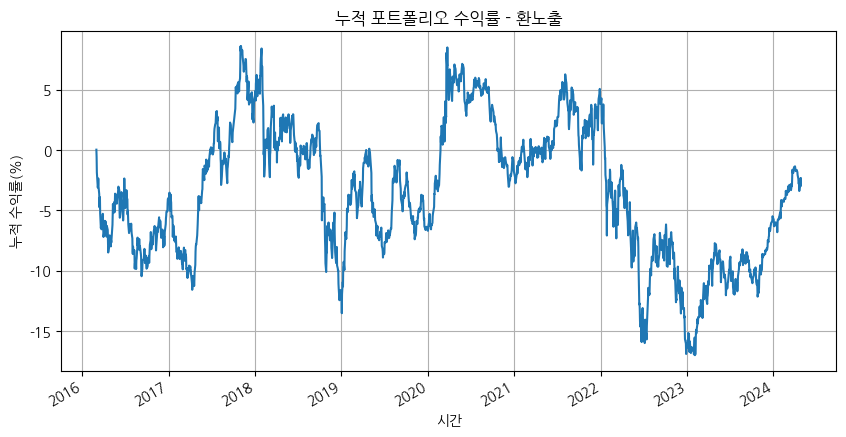

In [2894]:
import matplotlib.pyplot as plt

# 누적 포트폴리오 수익률 그래프
plt.figure(figsize=(10, 5))  # 그래프 크기 설정
plt.plot(portfolio_returns_explosure_percentile)  # 선 그래프
plt.title('누적 포트폴리오 수익률 - 환노출')  # 그래프 제목
plt.xlabel('시간')  # x축 라벨
plt.ylabel('누적 수익률(%)')  # y축 라벨
plt.grid(True)  # 그리드 표시

# x축 라벨이 겹치지 않도록 자동으로 조정
plt.gcf().autofmt_xdate()

plt.show()  # 그래프 보여주기

In [2895]:
trad_portfolio_returns_exposure = pd.DataFrame()

for i in range(0, 8):
    # 가중치 적용 결과 계산
    weighted_returns = np.array([0.3,0.3,0.2,0.2])

    print('가중치 : ', weighted_returns)
    print('예측 VAR : ',VaR_value(0.95, weighted_returns, hedged_data.iloc[256*(i):256*(i+1)])*100,'%')
    print('실제 VAR : ',VaR_value(0.95, weighted_returns, hedged_data.iloc[256*(i+1):256*(i+2)])*100,'%\n')

    # 다음 행에 대한 결과를 계산하여 연결
    new_returns = exposure_data.iloc[256*(i+1):256*(i+2)]@weighted_returns
    
    # 결과를 portfolio_returns에 추가
    trad_portfolio_returns_exposure = pd.concat([trad_portfolio_returns_exposure, new_returns])

# 결과 확인
trad_portfolio_returns_exposure.columns = ['포트폴리오 수익률']
print(trad_portfolio_returns_exposure)

가중치 :  [0.3 0.3 0.2 0.2]
예측 VAR :  -0.756573371037375 %
실제 VAR :  -0.487550035797626 %

가중치 :  [0.3 0.3 0.2 0.2]
예측 VAR :  -0.487550035797626 %
실제 VAR :  -0.557514197987095 %

가중치 :  [0.3 0.3 0.2 0.2]
예측 VAR :  -0.557514197987095 %
실제 VAR :  -0.7151006341098488 %

가중치 :  [0.3 0.3 0.2 0.2]
예측 VAR :  -0.7151006341098488 %
실제 VAR :  -1.4618488090906903 %

가중치 :  [0.3 0.3 0.2 0.2]
예측 VAR :  -1.4618488090906903 %
실제 VAR :  -0.6861659488504941 %

가중치 :  [0.3 0.3 0.2 0.2]
예측 VAR :  -0.6861659488504941 %
실제 VAR :  -0.998166139376466 %

가중치 :  [0.3 0.3 0.2 0.2]
예측 VAR :  -0.998166139376466 %
실제 VAR :  -0.8365021254165063 %

가중치 :  [0.3 0.3 0.2 0.2]
예측 VAR :  -0.8365021254165063 %
실제 VAR :  -0.7634117617206078 %

            포트폴리오 수익률
2016-03-02   0.014871
2016-03-03  -0.000531
2016-03-04  -0.005445
2016-03-07  -0.003495
2016-03-08  -0.008068
...               ...
2024-04-22   0.009481
2024-04-23   0.001540
2024-04-24   0.005074
2024-04-25  -0.010749
2024-04-26   0.009819

[1935 rows x 1 columns

In [2896]:
trad_portfolio_returns_exposure['누적 포트폴리오 수익률'] = (1 + trad_portfolio_returns_exposure['포트폴리오 수익률']).cumprod() - 1

In [2897]:
trad_portfolio_returns_exposure.index = pd.to_datetime(trad_portfolio_returns_exposure.index)
trad_portfolio_returns_data_exposure_percentile = trad_portfolio_returns_exposure['누적 포트폴리오 수익률']*100

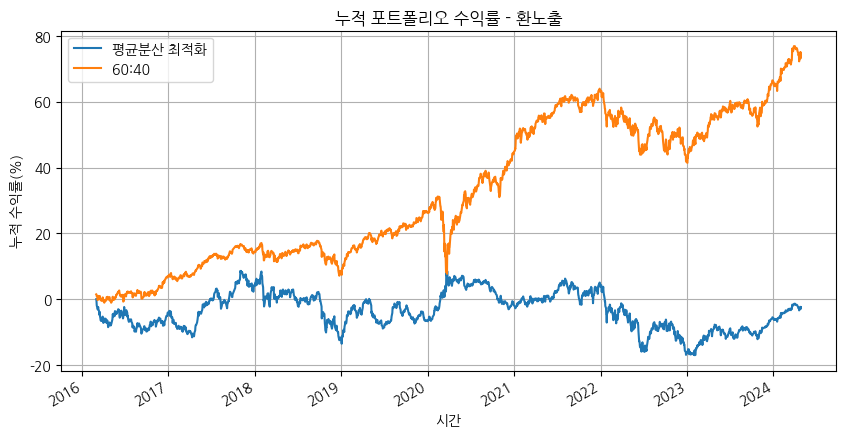

In [2898]:
import matplotlib.pyplot as plt
# 누적 포트폴리오 수익률 그래프
plt.figure(figsize=(10, 5))  # 그래프 크기 설정
plt.plot(portfolio_returns_explosure_percentile, label='평균분산 최적화')  # 선 그래프
plt.plot(trad_portfolio_returns_data_exposure_percentile, label='60:40')  # 선 그래프
plt.title('누적 포트폴리오 수익률 - 환노출')  # 그래프 제목
plt.xlabel('시간')  # x축 라벨
plt.ylabel('누적 수익률(%)')  # y축 라벨
plt.grid(True)  # 그리드 표시

# x축 라벨이 겹치지 않도록 자동으로 조정
plt.gcf().autofmt_xdate()

plt.legend()
plt.show()  # 그래프 보여주기

In [2899]:
cum_snp_exposure = (1 + exposure_data['S&P 500 - Exposure']).cumprod() - 1
cum_snp_exposure.index = pd.to_datetime(cum_snp_exposure.index)

cum_KSP_exposure = (1 + exposure_data['KOSPI 200']).cumprod() - 1
cum_KSP_exposure.index = pd.to_datetime(cum_KSP_exposure.index)

cum_KorB_exposure = (1 + exposure_data['Kor Bond']).cumprod() - 1
cum_KorB_exposure.index = pd.to_datetime(cum_KorB_exposure.index)

cum_USBond_exposure = (1 + exposure_data['US Bond - Exposure']).cumprod() - 1
cum_USBond_exposure.index = pd.to_datetime(cum_USBond_exposure.index)

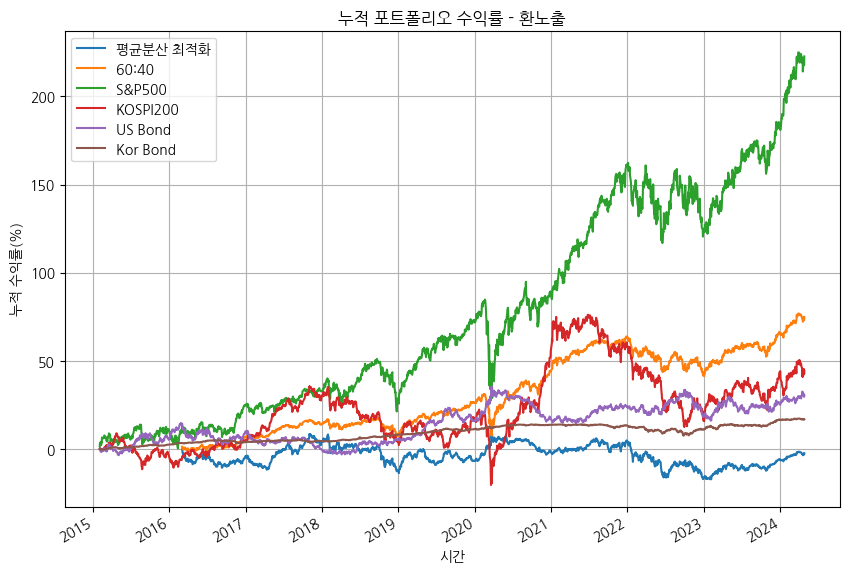

In [2900]:
import matplotlib.pyplot as plt
# 누적 포트폴리오 수익률 그래프
plt.figure(figsize=(10, 7))  # 그래프 크기 설정
plt.plot(portfolio_returns_explosure_percentile, label='평균분산 최적화')  # 선 그래프
plt.plot(trad_portfolio_returns_data_exposure_percentile, label='60:40')  # 선 그래프
plt.plot(cum_snp_exposure*100, label='S&P500')  # 선 그래프
plt.plot(cum_KSP_exposure*100, label='KOSPI200')
plt.plot(cum_USBond_exposure*100, label='US Bond')
plt.plot(cum_KorB_exposure*100, label='Kor Bond')
plt.title('누적 포트폴리오 수익률 - 환노출')  # 그래프 제목
plt.xlabel('시간')  # x축 라벨
plt.ylabel('누적 수익률(%)')  # y축 라벨
plt.grid(True)  # 그리드 표시

# x축 라벨이 겹치지 않도록 자동으로 조정
plt.gcf().autofmt_xdate()

plt.legend()
plt.show()  # 그래프 보여주기

---